In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

import time

import nltk
import unicodedata
import re

In [2]:
# hrefs = [] 
# for p in range(1,14):
#     url = f'https://github.com/search?p={p}&q=Hacktoberfest&type=Repositories'
#     response = requests.get(url)
#     soup = BeautifulSoup(response.text,'html.parser')
#     links = soup.find_all("a", {"class": "v-align-middle"})
#     links = [l['href'] for l in links]
#     hrefs.append(links)
#     time.sleep(15)
# flat_list = [item for sublist in hrefs for item in sublist]  


In [3]:
# """
# A module for obtaining repo readme and language data from the github API.
# Before using this module, read through it, and follow the instructions marked
# TODO.
# After doing so, run it like this:
#     python acquire.py
# To create the `data.json` file that contains the data.
# """
# import os
# import json
# from typing import Dict, List, Optional, Union, cast
# import requests

# from env import github_token, github_username

# # TODO: Make a github personal access token.
# #     1. Go here and generate a personal access token: https://github.com/settings/tokens
# #        You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
# #     2. Save it in your env.py file under the variable `github_token`
# # TODO: Add your github username to your env.py file under the variable `github_username`
# # TODO: Add more repositories to the `REPOS` list below.

# REPOS = flat_list

# headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

# if headers["Authorization"] == "token " or headers["User-Agent"] == "":
#     raise Exception(
#         "You need to follow the instructions marked TODO in this script before trying to use it"
#     )


# def github_api_request(url: str) -> Union[List, Dict]:
#     response = requests.get(url, headers=headers)
#     response_data = response.json()
#     if response.status_code != 200:
#         raise Exception(
#             f"Error response from github api! status code: {response.status_code}, "
#             f"response: {json.dumps(response_data)}"
#         )
#     return response_data


# def get_repo_language(repo: str) -> str:
#     url = f"https://api.github.com/repos{repo}"
#     repo_info = github_api_request(url)
#     if type(repo_info) is dict:
#         repo_info = cast(Dict, repo_info)
#         if "language" not in repo_info:
#             raise Exception(
#                 "'language' key not round in response\n{}".format(json.dumps(repo_info))
#             )
#         return repo_info["language"]
#     raise Exception(
#         f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
#     )


# def get_repo_contents(repo: str) -> List[Dict[str, str]]:
#     url = f"https://api.github.com/repos{repo}/contents/"
#     contents = github_api_request(url)
#     if type(contents) is list:
#         contents = cast(List, contents)
#         return contents
#     raise Exception(
#         f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
#     )


# def get_readme_download_url(files: List[Dict[str, str]]) -> str:
#     """
#     Takes in a response from the github api that lists the files in a repo and
#     returns the url that can be used to download the repo's README file.
#     """
#     for file in files:
#         if file["name"].lower().startswith("readme"):
#             return file["download_url"]
#     return ""


# def process_repo(repo: str) -> Dict[str, str]:
#     """
#     Takes a repo name like "gocodeup/codeup-setup-script" and returns a
#     dictionary with the language of the repo and the readme contents.
#     """
#     contents = get_repo_contents(repo)
#     readme_download_url = get_readme_download_url(contents)
#     if readme_download_url == "":
#         readme_contents = ""
#     else:
#         readme_contents = requests.get(readme_download_url).text
#     return {
#         "repo": repo,
#         "language": get_repo_language(repo),
#         "readme_contents": readme_contents,
#     }


# def scrape_github_data() -> List[Dict[str, str]]:
#     """
#     Loop through all of the repos and process them. Returns the processed data.
#     """
#     return [process_repo(repo) for repo in REPOS]


# if __name__ == "__main__":
#     data = scrape_github_data()
#     json.dump(data, open("data.json", "w"), indent=1)

In [4]:
df = pd.read_json('data.json')

In [5]:
df.shape

(130, 3)

In [6]:
df.readme_contents.head()

0    # 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...
1    Hacktoberfest-2022\n\n**Checkout this Project ...
2    <div align="centre">\n    <b>dont contribute i...
3    # HacktoberFest 2022 `OPEN FIRST` Pull Request...
4    # HacktoberFest- Contribute to Open-Source.\n\...
Name: readme_contents, dtype: object

In [7]:
import nltk
import unicodedata
import re

def clean_text(text, extra_stopwords=[]):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    words = re.sub(r'[^\w\s___]', '', clean_text).split()
    words = re.sub(r'_', '',' '.join(words)).split(' ')
    words = [w for w in words if len(w)<25]
    return [wnl.lemmatize(word) for word in words if word not in stopwords]





In [8]:
df['lem'] = df.readme_contents.apply(clean_text)

In [9]:
def jupy_replace(df):
    new_lang = ['C++', 'C++','C++','python','python','python', 'python', 'python',
                 'python', 'python', 'python', 'python', 'python', 'C++',
                 'python', 'C++', 'python', 'python', 'python', 'HTML', 'python',
                 'Javascript']
    repo_mod = pd.DataFrame(df[df['language']== 'Jupyter Notebook']['repo'])
    repo_mod['new_lang'] = new_lang
    for x in repo_mod.index:
        df.loc[x, 'language'] = repo_mod.loc[x, 'new_lang']
    return df

def clean_lang(df):
    df.language = df.language.str.lower()
    invalid = list(set(list(df.language.value_counts().index))-set(['c++', 'python', 'html']))
    invalid_index = df[df.language.isin(invalid)]['language'].index
    df.loc[invalid_index,'language']='other'
    df.loc[df[df.language.isna()].index,'language']='other'
    return df

In [10]:
df = jupy_replace(df)
df = clean_lang(df)

In [11]:
from sklearn.model_selection import train_test_split
def split_data(df, target):
    
    '''
    Splits a df into a train, validate, and test set. 
    target is the feature you will predict
    '''
    full = df
    train_validate, test = train_test_split(df, train_size =.8, random_state = 21)
    train, validate = train_test_split(train_validate, train_size = .7, random_state = 21)
    X_train = train.drop(columns=target)
    y_train = train[target]
    X_val = validate.drop(columns=target)
    y_val = validate[target]
    X_test = test.drop(columns=target)
    y_test = test[target]
    
    
    return train, X_train, y_train, X_val, y_val, X_test, y_test

train, X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'language')

In [12]:
X_train.shape

(72, 3)

In [13]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")


,n,percent
other,24,0.333333
c++,19,0.263889
html,17,0.236111
python,12,0.166667


In [14]:
train

,repo,language,readme_contents,lem
92,/codedamn/codedamn-hacktoberfest-projects,html,"# DISCLAIMER\n""This repository is no longer ac...","[disclaimer, repository, longer, accepting, pr..."
39,/OpenSourceTogether/Hacktoberfest-2020,other,# Hey! Welcome to the Hacktoberfest 2020\n\n##...,"[hey, welcome, hacktoberfest, 2020, disclaimer..."
24,/sbmxc/hacktoberfest,python,# HacktoberFest is here!!\n\nUse this reposit...,"[hacktoberfest, use, repository, make, first, ..."
124,/dikshantrajput/Hacktoberfest-accepted-2022,c++,"<h1 align=""center""> <img src= ""https://octodex...","[h1, aligncenter, img, src, width, 40, hacktob..."
80,/adarshpand3y/Hacktoberfest2022-DSA,other,\n# 🎃 Hacktoberfest2022-DSA 💻\n\nParticipate i...,"[hacktoberfest2022dsa, participate, hacktoberf..."
...,...,...,...,...
75,/TheOdinProject/css-exercises,html,# CSS Exercises\n\nThese exercises are a serie...,"[cs, exercise, exercise, series, cs, related, ..."
17,/Joonsang1994/Hacktoberfest,other,![Open Source Love](https://badges.frapsoft.co...,"[open, source, first, pull, request, hacktober..."
93,/bajajvinamr/HacktoberFest2020,html,# Hacktoberfest-2020\nhttps://hacktoberfest.di...,"[hacktoberfest2020, contribute, submit, pull, ..."
129,/Shreyasheeetal20/HACKTOBERFEST22,html,# HACKTOBERFEST22\nThis repository is for ever...,"[hacktoberfest22, repository, everyone, want, ..."


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer



In [16]:
def join(col):
    return ' '.join(col)
df['model'] = df.lem.apply(join)

In [17]:
from sklearn.model_selection import train_test_split
def split_data(df, target):
    
    '''
    Splits a df into a train, validate, and test set. 
    target is the feature you will predict
    '''
    full = df
    train_validate, test = train_test_split(df, train_size =.8, random_state = 21)
    train, validate = train_test_split(train_validate, train_size = .7, random_state = 21)
    X_train = train.drop(columns=target)
    y_train = train[target]
    X_val = validate.drop(columns=target)
    y_val = validate[target]
    X_test = test.drop(columns=target)
    y_test = test[target]
    
    
    return train, X_train, y_train, X_val, y_val, X_test, y_test

train, X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'language')

In [35]:

tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train.model)
tfidf_val = tfidf.transform(X_val.model)
tfidf_test = tfidf.transform(X_test.model)

In [36]:

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)
    
lm = LogisticRegression().fit(tfidf_train, y_train.language)
y_train['predict_lm'] = lm.predict(tfidf_train)
y_val['predict_lm'] = lm.predict(tfidf_val)
y_test['predict_lm'] = lm.predict(tfidf_test)

rf = RandomForestClassifier().fit(tfidf_train, y_train.language)
y_train['predict_rf'] = rf.predict(tfidf_train)
y_val['predict_rf'] = rf.predict(tfidf_val)
y_test['predict_rf'] = rf.predict(tfidf_test)

knn = KNeighborsClassifier(n_neighbors=3).fit(tfidf_train, y_train.language)
y_train['predict_knn'] = knn.predict(tfidf_train)
y_val['predict_knn'] = knn.predict(tfidf_val)
y_test['predict_knn'] = knn.predict(tfidf_test)

dt = DecisionTreeClassifier(max_depth=3).fit(tfidf_train, y_train.language)
y_train['predict_dt'] = dt.predict(tfidf_train)
y_val['predict_dt'] = dt.predict(tfidf_val)
y_test['predict_dt'] = dt.predict(tfidf_test)

In [37]:
def print_confusion_matrix(df,col):
    print('Accuracy: {:.2%}'.format(accuracy_score(df.language, df[col])))
    print('---')
    print('Confusion Matrix')
    print(pd.crosstab(df[col], df.language))
    print('---')
    print(classification_report(df.language, df[col]))

In [38]:
def print_accuracy(df,col):
    print('Accuracy: {:.2%}'.format(accuracy_score(df.language, df[col])))
    print('---')

In [39]:
y_train

,language,predict_lm,predict_rf,predict_knn,predict_dt
92,html,html,html,c++,other
39,other,other,other,c++,other
24,python,other,python,c++,other
124,c++,other,c++,c++,other
80,other,other,other,other,other
...,...,...,...,...,...
75,html,html,html,c++,html
17,other,other,other,c++,other
93,html,other,html,other,other
129,html,html,html,html,other


In [40]:
import matplotlib.pyplot as plt

In [41]:
def accuracy_df(y_train,y_val):
    columns = ['predict_lm', 'predict_rf', 'predict_knn', 'predict_dt']
    name = []
    train = [] 
    val = []
    for c in columns:
        name.append(c)
        train.append(accuracy_score(y_train.language, y_train[c]))
        val.append(accuracy_score(y_val.language, y_val[c]))
    return pd.DataFrame({'model':name,'train':train,'validate':val}).set_index('model')

In [42]:
train

[0.8611111111111112, 1.0, 0.5416666666666666, 0.5277777777777778]

In [43]:
accuracy = pd.DataFrame({'model':name,'train':train,'validate':val}).set_index('model')

In [44]:
accuracy

,train,validate
model,,
predict_lm,0.861111,0.3750
predict_rf,1.000000,0.3125
predict_knn,0.541667,0.3125
predict_dt,0.527778,0.3125


In [45]:
def viz_models_accuracy(df):
    '''takes in a dataframe and plot a graph to show comparisons models accuracy score on train and valiadate data'''
    df = df.copy()
    df.train = df.train *100
    df.validate = df.validate *100
    ax = df.plot.bar(rot=75)
    ax.spines[['right', 'top']].set_visible(False)
    plt.title('Comparisons of Accuracy')
    plt.ylabel('Accuracy score')
    plt.bar_label(ax.containers[0],fmt='%.0f%%')
    plt.bar_label(ax.containers[1],fmt='%.0f%%')
    plt.show()

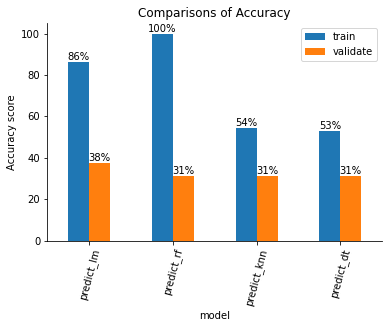

In [47]:
viz_models_accuracy(accuracy)